In [79]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from tqdm import tqdm
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import time
import requests
import io
import itertools

## Data Preparation

### CSV Data

In [68]:
raw = pd.read_csv('./data/tr_eikon_eod_data.csv', 
                  index_col=0, parse_dates=True)

In [69]:
selected = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']

In [70]:
data = pd.DataFrame(raw[selected].dropna())

In [71]:
for stock in selected:
    data['Returns_' + stock] = np.log(data[stock] / data[stock].shift(1)).dropna()
    data['Returns_' + stock].fillna(0, inplace=True)
    data['direction_' + stock] = np.sign(data['Returns_' + stock]).dropna().astype(int)

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/1471193878.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Returns_' + stock].fillna(0, inplace=True)
/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/1471193878.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

In [72]:
split = int(len(data)*0.8)
data_train = data.iloc[:split].copy()
data_test = data.iloc[split:].copy()

### Additional Info

In [73]:
selected_yf = ['AAPL', 'MSFT', 'INTC', 'AMZN', 'GS']

In [74]:
data_yf = {}

In [75]:
for stock in selected_yf:
    df = yf.download(stock, start='2010-01-04', end='2018-06-30', auto_adjust=False)
    data_yf[selected[selected_yf.index(stock)]] = df

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Training

In [76]:
def augment_features(dataframe):
    fracocp = (dataframe['Close']-dataframe['Open'])/dataframe['Open']
    frachp = (dataframe['High']-dataframe['Open'])/dataframe['Open']
    fraclp = (dataframe['Open']-dataframe['Low'])/dataframe['Open']
    new_dataframe = pd.DataFrame({'delOpenClose': fracocp,
                                 'delHighOpen': frachp,
                                 'delLowOpen': fraclp})
    new_dataframe.set_index(dataframe.index)
    
    return new_dataframe

In [77]:
def extract_features(dataframe):
    return np.column_stack((dataframe['delOpenClose'], dataframe['delHighOpen'], dataframe['delLowOpen']))

In [87]:
def train_model(dataframe):
    train_size = int(0.8*dataframe.shape[0])
    train_data = dataframe.iloc[0:train_size]
    test_data = dataframe.iloc[train_size:]

    augmented = augment_features(train_data)
    features = extract_features(augmented)

    model = GaussianHMM(n_components=10)
    model.fit(features)

    test_augmented = augment_features(test_data)
    fracocp = test_augmented['delOpenClose']
    frachp = test_augmented['delHighOpen']
    fraclp = test_augmented['delLowOpen']

    sample_space_fracocp = np.linspace(fracocp.min(), fracocp.max(), 50)
    sample_space_fraclp = np.linspace(fraclp.min(), frachp.max(), 10)
    sample_space_frachp = np.linspace(frachp.min(), frachp.max(), 10)

    possible_outcomes = np.array(list(itertools.product(sample_space_fracocp, sample_space_frachp, sample_space_fraclp)))

    num_latent_days = 50
    num_days_to_predict = test_data.shape[0]

    predicted_close_prices = []
    for i in tqdm(range(num_days_to_predict)):
        # Calculate start and end indices
        previous_data_start_index = max(0, i - num_latent_days)
        previous_data_end_index = max(0, i)
        # Acquire test data features for these days
        previous_data = extract_features(augment_features(test_data.iloc[previous_data_start_index:previous_data_end_index]))
        
        outcome_scores = []
        for outcome in possible_outcomes:
            # Append each outcome one by one with replacement to see which sequence generates the highest score
            total_data = np.row_stack((previous_data, outcome))
            outcome_scores.append(model.score(total_data))
            
        # Take the most probable outcome as the one with the highest score
        most_probable_outcome = possible_outcomes[np.argmax(outcome_scores)]
        predicted_close_prices.append(test_data.iloc[i]['Open'] * (1 + most_probable_outcome[0]))
    
    return model, predicted_close_prices

In [85]:
models = {}
predictions = {}

In [88]:
for stock in selected:
    model, predicted_close_prices = train_model(data_yf[stock])
    models[stock] = model
    predictions[stock] = predicted_close_prices

100%|██████████| 428/428 [15:27<00:00,  2.17s/it]


In [95]:
len(predictions['AAPL.O'])

428

In [99]:
stock = 'AAPL.O'
dataframe = data_yf[stock]
predicted_close_prices = predictions[stock]
train_size = int(0.8*dataframe.shape[0])

In [103]:
train_data = dataframe.iloc[0:train_size]
test_data = dataframe.iloc[train_size+1:]
test_data.shape

(427, 6)

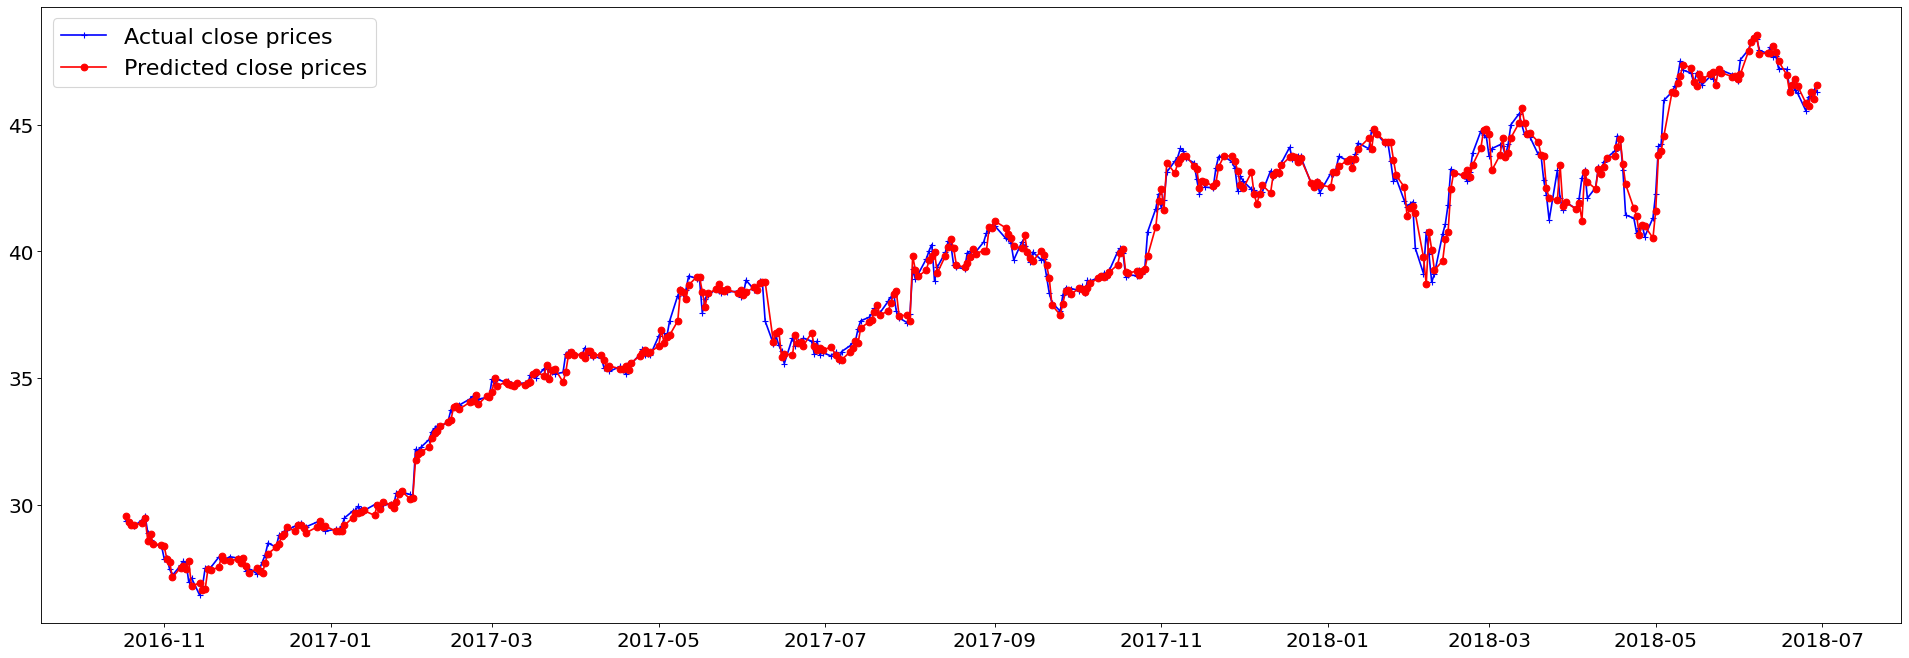

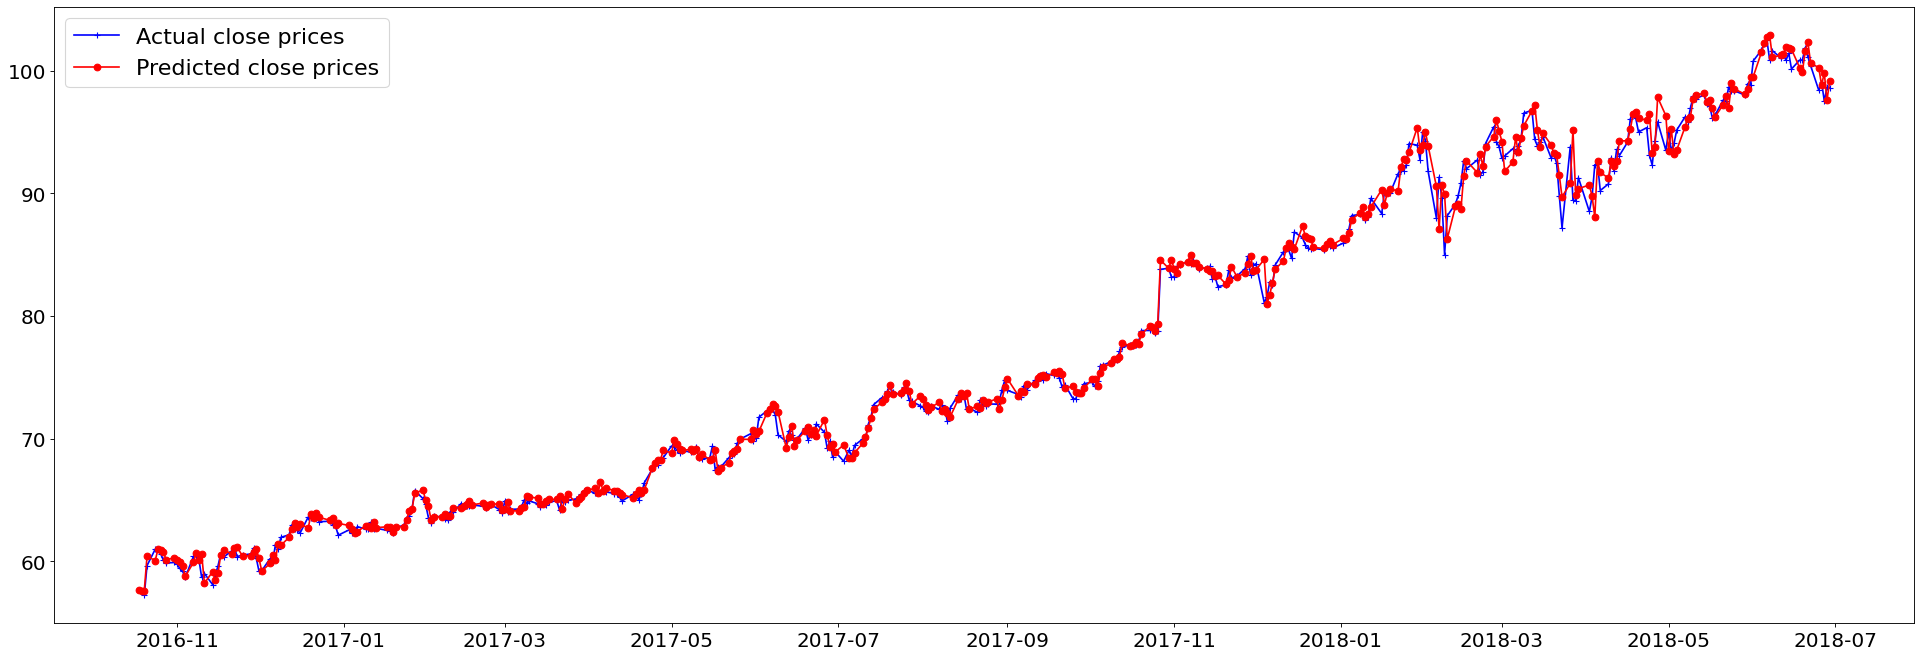

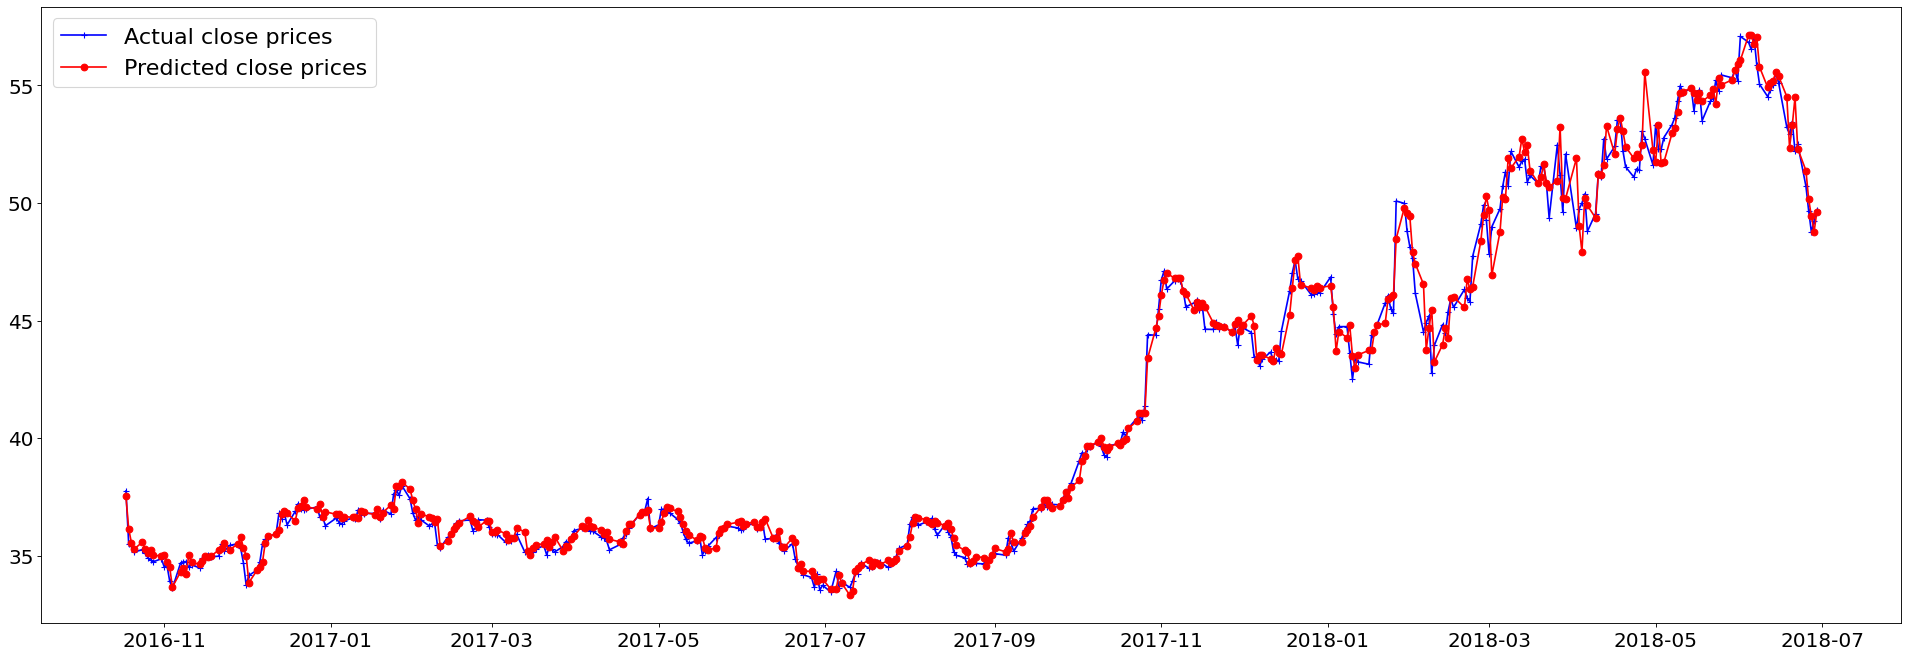

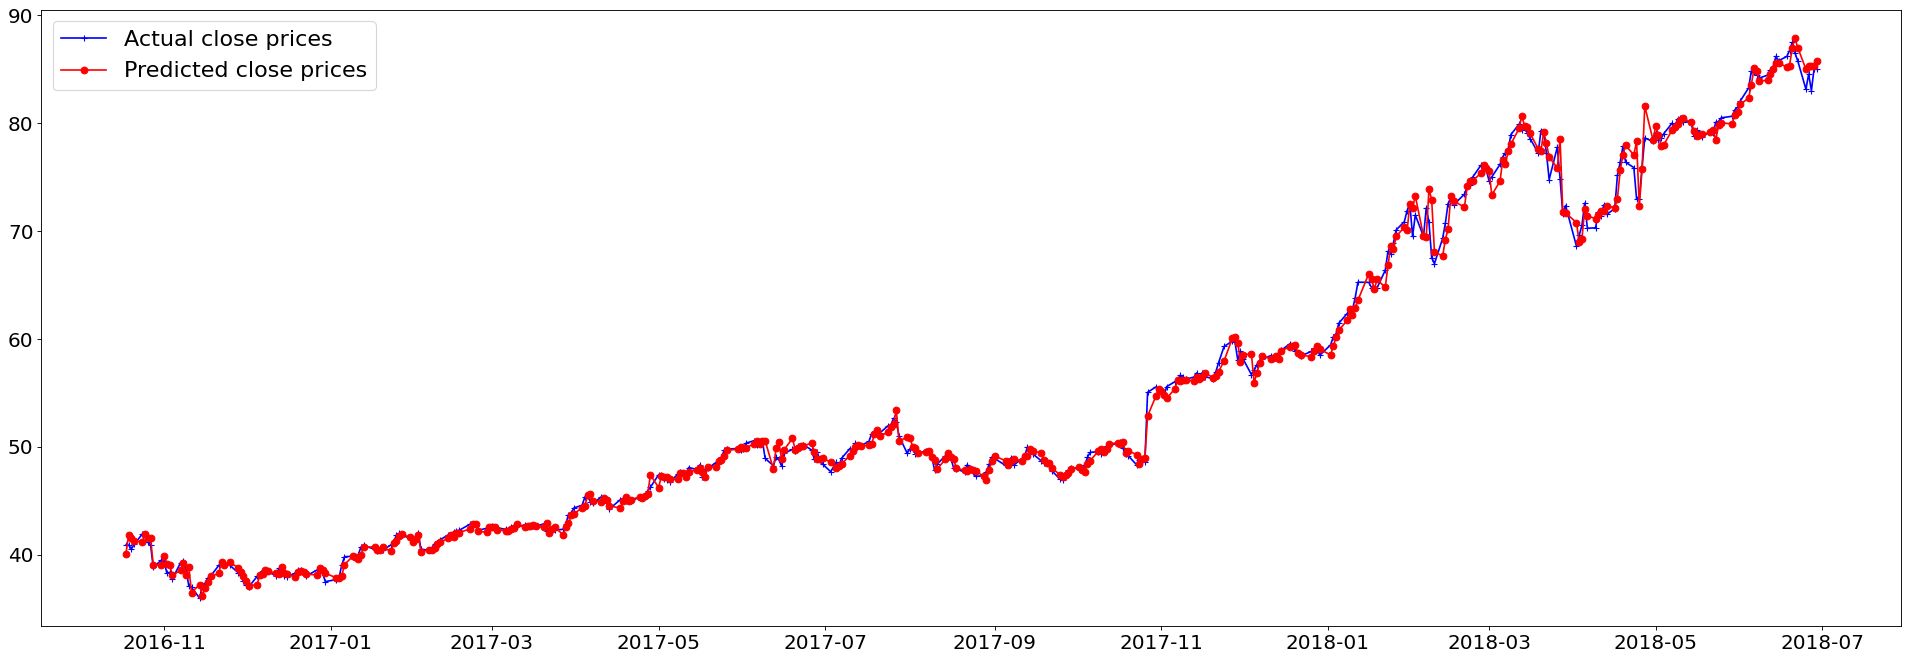

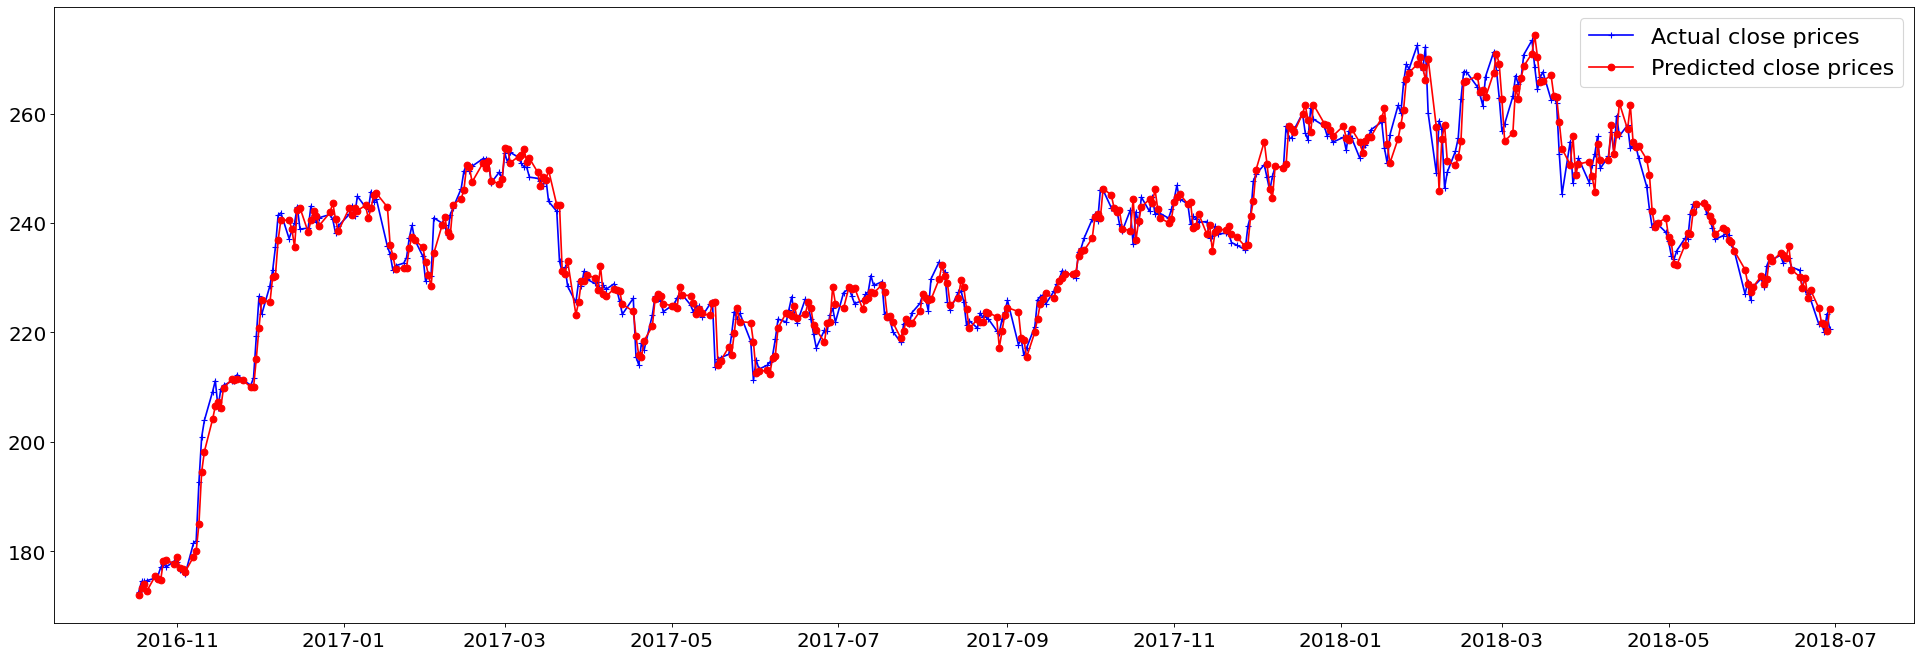

In [105]:
for stock in selected:
    dataframe = data_yf[stock]
    predicted_close_prices = predictions[stock]

    train_size = int(0.8*dataframe.shape[0])
    train_data = dataframe.iloc[0:train_size]
    test_data = dataframe.iloc[train_size:]
    num_days_to_predict = test_data.shape[0]

    plt.figure(figsize=(30,10), dpi=80)
    plt.rcParams.update({'font.size': 18})

    x_axis = np.array(test_data.index, dtype='datetime64[ms]')
    plt.plot(x_axis, test_data.iloc[0:num_days_to_predict]['Close'], 'b+-', label="Actual close prices")
    plt.plot(x_axis, predicted_close_prices, 'ro-', label="Predicted close prices")
    plt.legend(prop={'size': 20})
    plt.show()

In [115]:
for stock in selected:
    print('--' + stock + '--')
    df = data_yf[stock]
    df = df[int(0.8*dataframe.shape[0]):]
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Direction'] = np.sign(df['Return']).dropna().astype(int)

    predicted_close_prices = predictions[stock]
    df['Predicted'] = predicted_close_prices
    df['Predicted_Return'] = np.log(df['Predicted'] / df['Predicted'].shift(1))
    df['Signal'] = np.sign(df['Predicted_Return']).dropna().astype(int)
    print((df['Signal'] != df['Direction']).sum() / len(df['Signal']))

    df['Returns_benchmark'] = df['Return'] * df['Direction']
    df['Returns_strategy'] = df['Return'] * df['Signal']
    print(df[['Returns_benchmark', 'Returns_strategy']].sum().apply(np.exp))

--AAPL.O--
0.42289719626168226
Returns_benchmark    40.291091
Returns_strategy      3.835858
dtype: float64
--MSFT.O--
0.4976635514018692
Returns_benchmark    35.418074
Returns_strategy      1.593861
dtype: float64
--INTC.O--
0.40186915887850466
Returns_benchmark    81.046983
Returns_strategy      4.040409
dtype: float64
--AMZN.O--
0.3855140186915888
Returns_benchmark    86.408185
Returns_strategy      4.785558
dtype: float64
--GS.N--
0.4205607476635514
Returns_benchmark    78.315455
Returns_strategy      3.144256
dtype: float64


/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/2174278251.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/2174278251.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Direction'] = np.sign(df['Return']).dropna().astype(int)
/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/2174278251.py:9: SettingWithCopyWarning: 
A value is trying to be set on

/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/378546171.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/378546171.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Direction'] = np.sign(df['Return']).dropna().astype(int)
/var/folders/2b/tgv3r4pj32b_81f22_mtv7bh0000gn/T/ipykernel_17876/378546171.py:8: SettingWithCopyWarning: 
A value is trying to be set on a 

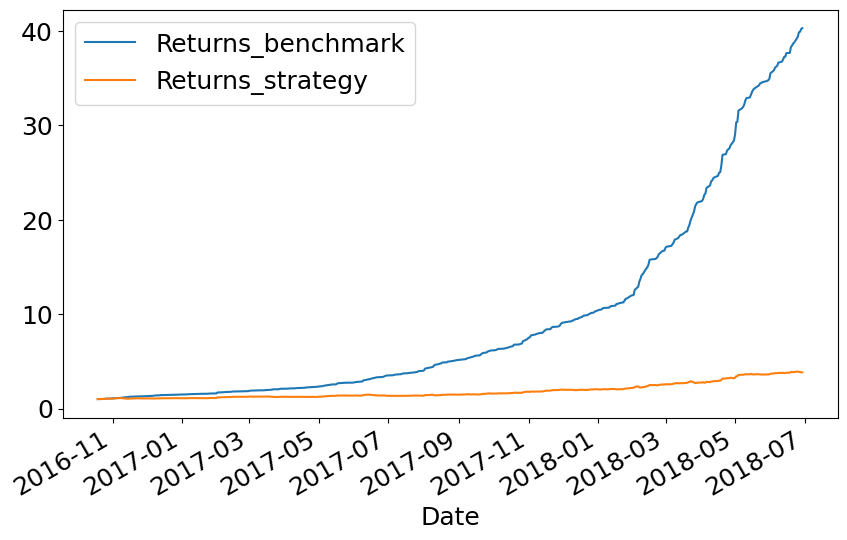

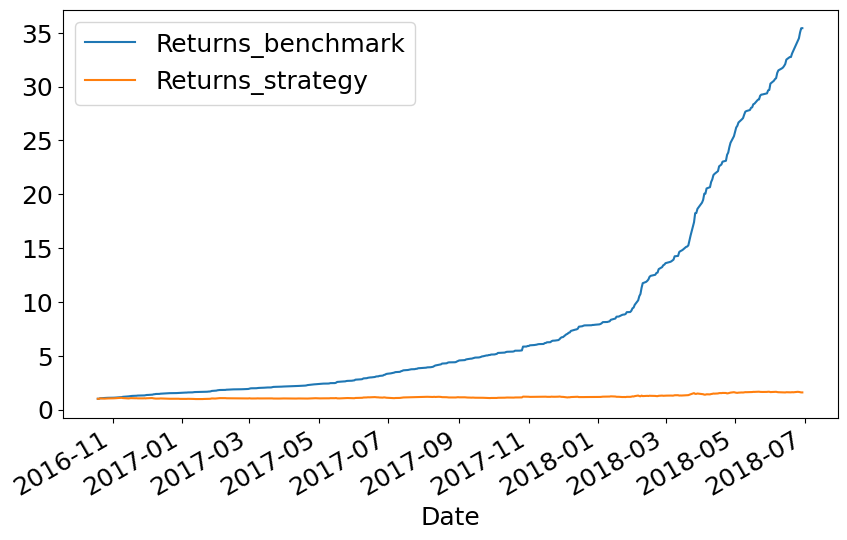

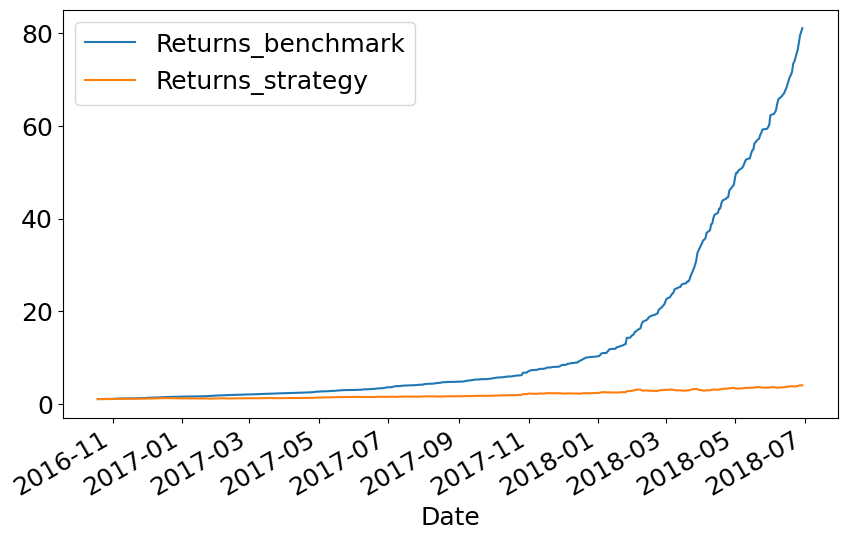

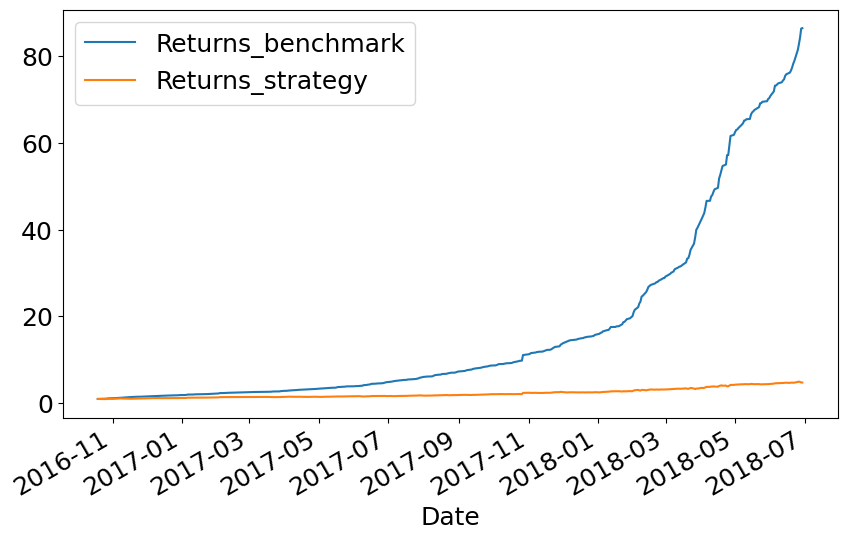

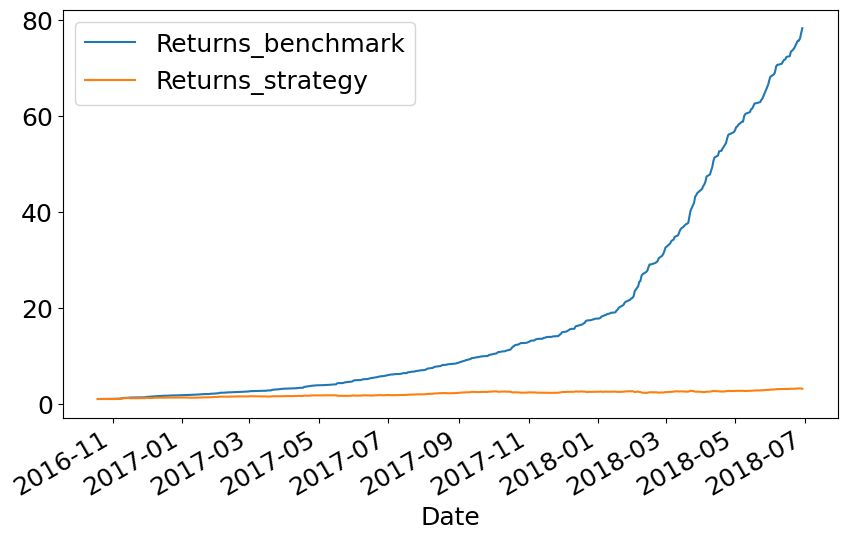

In [117]:
for stock in selected:
    df = data_yf[stock]
    df = df[int(0.8*dataframe.shape[0]):]
    df['Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Direction'] = np.sign(df['Return']).dropna().astype(int)

    predicted_close_prices = predictions[stock]
    df['Predicted'] = predicted_close_prices
    df['Predicted_Return'] = np.log(df['Predicted'] / df['Predicted'].shift(1))
    df['Signal'] = np.sign(df['Predicted_Return']).dropna().astype(int)

    df['Returns_benchmark'] = df['Return'] * df['Direction']
    df['Returns_strategy'] = df['Return'] * df['Signal']

    df[['Returns_benchmark', 'Returns_strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))